# Introduction

This Python notebook applies Facebook's Movement Range Maps dataset, originally intended for monitoring the effects of lockdowns on human movement during the COVID-19 pandemic, to a new use case: natural disasters.

Movement Range Maps is a dataset released by Facebook and made publicly available for several countries on the Humanitarian Data Exchange. The dataset provides daily datapoints since February 2020 on two metrics: (i) Relative change in the proportion of Bing tiles visited by Facebook users per day, and (ii) proportion of Facebook users staying in a single Bing tile all day.

# Imports

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import webbrowser  
from zipfile import ZipFile

# for plotting time series
from datetime import datetime
# registering converters for plotting datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import urllib.request


In [2]:
# HDX Imports
from hdx.utilities.easy_logging import setup_logging
from hdx.hdx_configuration import Configuration
Configuration.create(hdx_site='prod', hdx_read_only=True,user_agent='WBG')
from hdx.data.dataset import Dataset
import os
from sys import path
import shutil
import webbrowser  


# Functions

In [3]:
class read_mobility():
    def __init__(self):
        pass
    
    @staticmethod
    def unzip(filepath):
    # Create a ZipFile Object and load sample.zip in it
        with ZipFile(filepath, 'r') as zipObj:
       # Extract all the contents of zip file in current directory
           zipObj.extractall(filepath[:-4])        
        
    @staticmethod    
    def download_from_hdx():
        '''
        Function to download latest movement range maps from HDX.
        '''
        url, path = Dataset.get_resources(Dataset.read_from_hdx('movement-range-maps'))[1].download('data/mobility_data/')
        print('\nResource URL %s downloaded to %s' % (url, path))
        
        
        #     @staticmethod    
    def read_from_hdx(self):
        '''
        Function to download latest movement range maps from HDX.
        '''
        url = Dataset.get_resources(Dataset.read_from_hdx('movement-range-maps'))[1]
        name = url['name']
        print(f'Latest file available is {name[:-4]}')
        self.latest = name
        if self.latest in os.listdir('data/mobility_data/'):
            print(f'Movement range data for {name[:-4]} already exists. Skipping download.')
        else:
            self.download_from_hdx()
    
    def download_from_gadm(self,countries):
        for country in countries:
            url = f'https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_{country}_shp.zip'
            filepath = f'data/boundaries/{country}.zip'
            if os.path.exists(filepath):
                print(f'Boundary data for {country} already exists. Skipping download.')
            else:
                urllib.request.urlretrieve(url, filepath)
            if os.path.exists(filepath[:-4]):
                print(f'Boundary data for {country} already unzipped.')
            else:
                print(f'Unzipping boundary data for {country}.')
                self.unzip(filepath)

    def read_facebook_data(self):
        zf = ZipFile('data/mobility_data/'+self.latest)
        self.date = self.latest[-14:-4]
        data = pd.read_csv(zf.open(f'movement-range-{self.date}.txt'),sep='\t')
        data['ds'] = pd.to_datetime(data['ds'])
        data['all_day_bing_tiles_visited_percent_change'] = data['all_day_bing_tiles_visited_relative_change']*100
        data['all_day_percent_single_tile_users'] = data['all_day_ratio_single_tile_users']*100
        return data

In [4]:
class mobility_analytics:
    def __init__(self,countries):
        self.countries = countries
        self.shapefiles = {}
        for c in self.countries:
            self.shapefiles[c] = gpd.read_file(f'data/boundaries/{c}/gadm36_{c}_2.shp')
    
    def select_affected_from_names(self,shapefile):
        col0 = []
        col1 = []
        col2 = []
        data = pd.DataFrame()
        for n in range(3):
            col_names = [i for i in shapefile.columns if (i[-1]==str(n)) & ('NAME' in i) &('NL_NAME' not in i) ]
            if 'VARNAME_' + str(n) in col_names:
                col = 'VARNAME_' + str(n)
            else:
                col = 'NAME_' + str(n)
            names = shapefile[col].sort_values().unique()
            dict_ = dict(list(zip(range(len(names)),names)))

            if n==0:
                print('Was the whole country affected?')
                x = ''
                while (x != 'Y') & (x != 'N'):
                    print('Enter Y or N.')
                    x = input()

                if x == 'Y':
                    data = shapefile
                    print('Including whole country in analysis extent.\n')
                    break

            elif n==1:
                print('\nSelect provinces that were affected. Separate each number with commas. Hit enter to skip provinces and move to cities/towns/municipalities.\n')
                print(dict_)
                print()
                x = input()
                if x != '':
                    data = pd.concat([data,shapefile[shapefile[col].isin([dict_[int(i)] for i in x.split(',')])]])
                    print('Selected provinces: ', [dict_[int(i)] for i in x.split(',')])
                elif x=='':
                    print('No provinces selected.\n')

            elif n==2:
                y = 1
                while y!= '' :
                    print('Hit enter to continue.')
                    y = input() 

                print('\nSelect cities/towns/municipalities that were affected. Separate each number with commas.\n')
                print(dict_)
                print()
                x = input()
                if x != None:
                    data = pd.concat([data,shapefile[shapefile[col].isin([dict_[int(i)] for i in x.split(',')])]])
                    print('Selected cities/municipalities: ', [dict_[int(i)] for i in x.split(',')])

                elif x=='':
                    print('No cities/towns/municipalities selected.\n')                
    #                 data = shapefile

        return data
    
    def find_affected(self,custom={}):
        affected = {}
        for c in self.countries:
            shapefile = self.shapefiles[c]
            if c in custom.keys():
                print(f'\nShapefile for {c} passed. Processing...')
                affected[c] = shapefile[shapefile.centroid.within(custom[c].geometry.squeeze())]
            else:
                print(f'\nNo shapefile passed for affected areas in {c}.')
                affected[c] = self.select_affected_from_names(gadm_vnm)
        return affected


# Downloading and Reading data

In [5]:
r = read_mobility()
r.download_from_gadm(['VNM','PHL'])
r.read_from_hdx()
data = r.read_facebook_data()

Boundary data for VNM already exists. Skipping download.
Boundary data for VNM already unzipped.
Boundary data for PHL already exists. Skipping download.
Boundary data for PHL already unzipped.
Latest file available is movement-range-data-2021-02-02
Movement range data for movement-range-data-2021-02-02 already exists. Skipping download.


/Users/mahamfaisalkhan/anaconda3/envs/wbg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
m = mobility_analytics(['VNM','PHL'])
vnm_custom = gpd.read_file('data/disaster_extents/vietnam_flooding/vnm_extent.shp')
phl_custom = gpd.read_file('data/disaster_extents/philippines_flooding/phl_extent.shp')
affected_dict = {'VNM':vnm_custom,'PHL':phl_custom}
affected = m.find_affected(affected_dict)



Shapefile for VNM passed. Processing...

Shapefile for PHL passed. Processing...


# Comparing national trends

In [7]:
color = 'lightgrey'
alpha = 0.1
fontsize=9

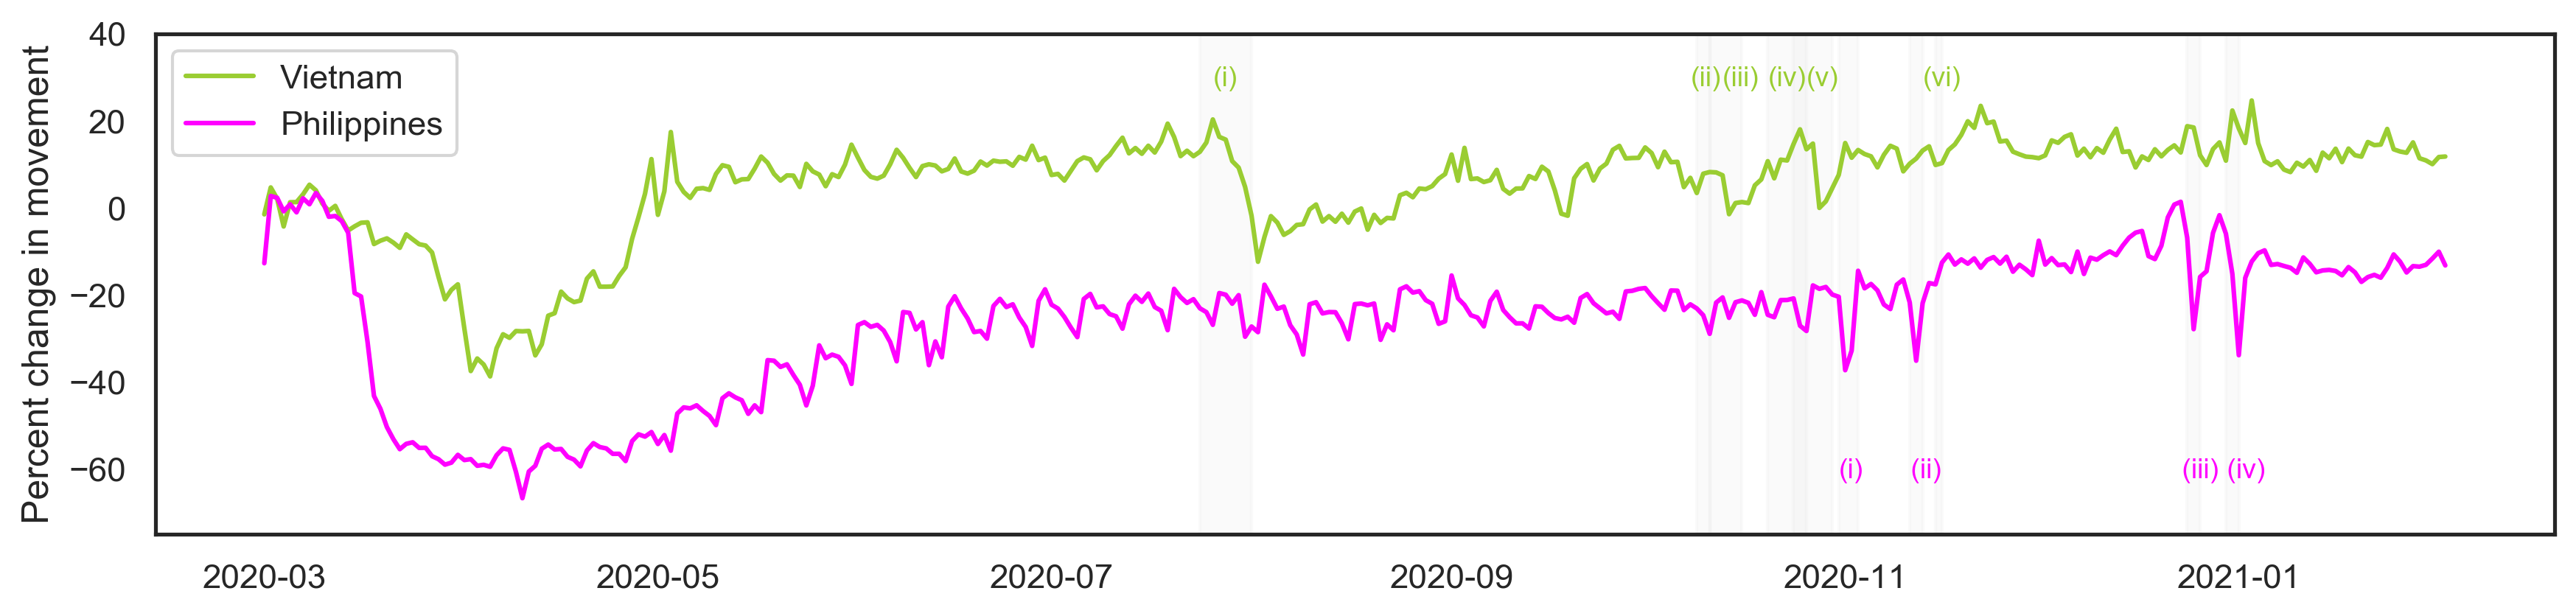

In [8]:
fig, ax = plt.subplots(figsize=(14,3),dpi=300)

label_height = 28

sns.lineplot(data=data[data['country'].isin(['VNM'])].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='yellowgreen',ax=ax)
sns.lineplot(data=data[data['country'].isin(['PHL'])].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='magenta',ax=ax)
plt.legend(['Vietnam','Philippines'])
plt.ylabel('Percent change in movement')
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,12,24),datetime(2020,12,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,12,30),datetime(2021,1,1),color=color,zorder=-10,alpha=alpha)

plt.text(datetime(2020,10,31),-62,'(i)',fontsize=fontsize,color='magenta')
plt.text(datetime(2020,11,10),-62,' (ii)',fontsize=fontsize,color='magenta')
plt.text(datetime(2020,12,22),-62,' (iii)',fontsize=fontsize,color='magenta')
plt.text(datetime(2020,12,29),-62,' (iv)',fontsize=fontsize,color='magenta')


plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),label_height,'(i)',fontsize=fontsize,color='yellowgreen')
plt.text(datetime(2020,10,8),label_height,'(ii)',fontsize=fontsize,color='yellowgreen')
plt.text(datetime(2020,10,13),label_height,'(iii)',fontsize=fontsize,color='yellowgreen')
plt.text(datetime(2020,10,20),label_height,'(iv)',fontsize=fontsize,color='yellowgreen')
plt.text(datetime(2020,10,26),label_height,'(v)',fontsize=fontsize,color='yellowgreen')
plt.text(datetime(2020,11,13),label_height,'(vi)',fontsize=fontsize,color='yellowgreen')

plt.ylim([-75,40])
plt.xlabel('')

plt.show()


# Plotting disaster event

## Vietnam

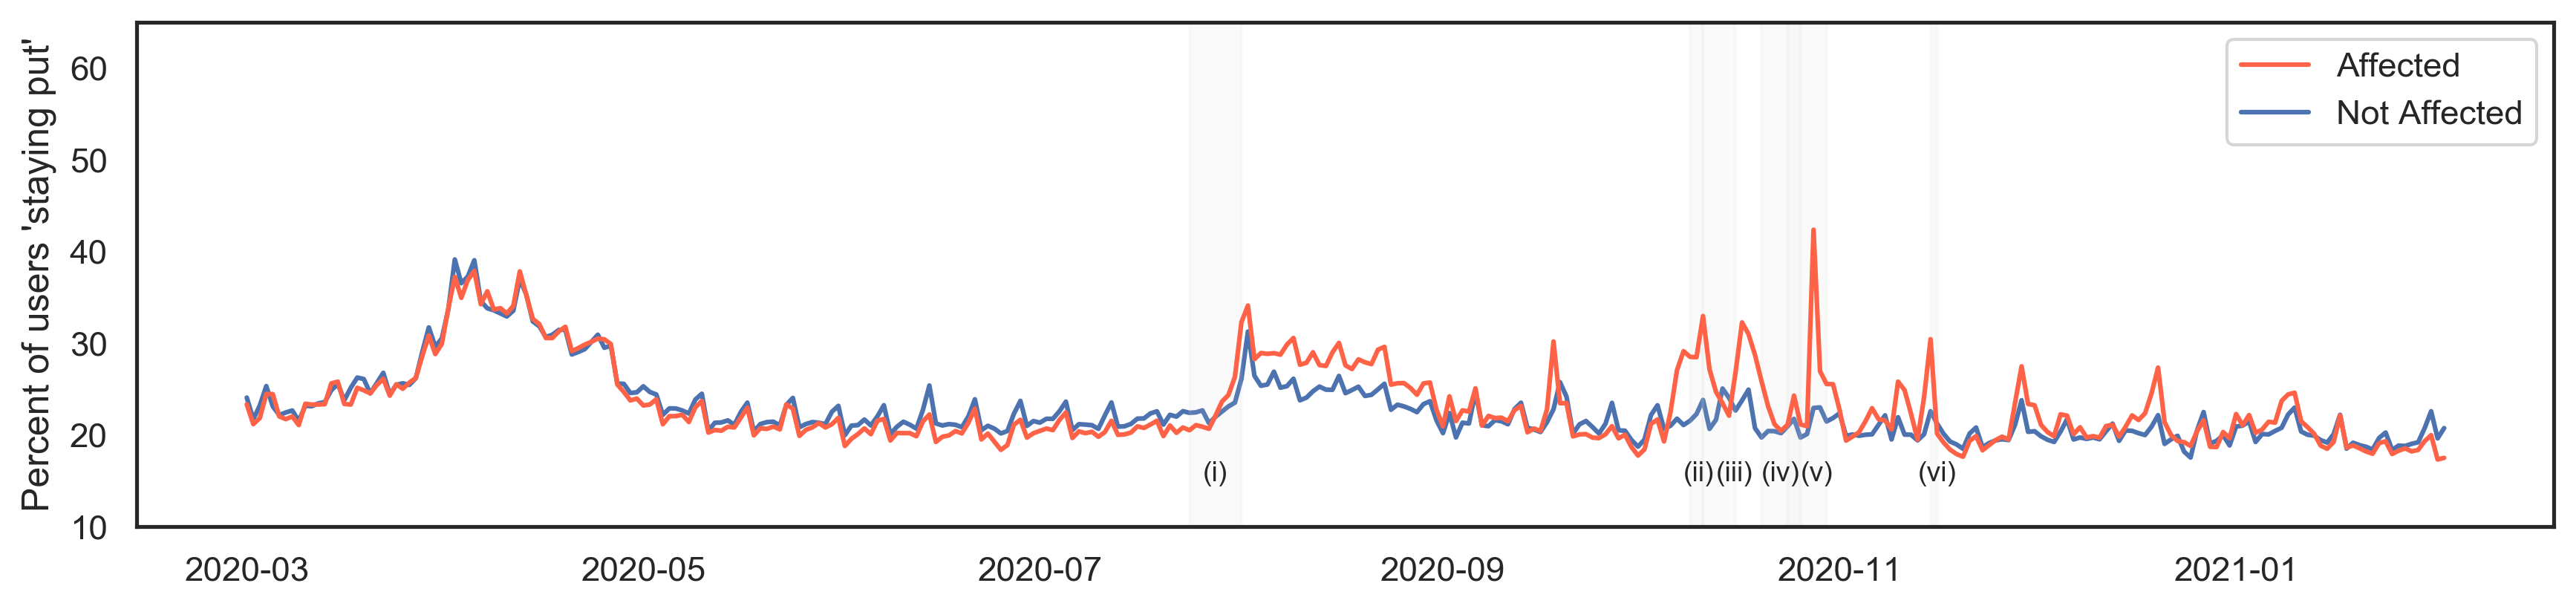

In [9]:
fig, ax = plt.subplots(figsize=(14,3),dpi=300)

sns.lineplot(data=data[data['polygon_id'].isin(affected['VNM']['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',color='Tomato',ax=ax,zorder=100)
sns.lineplot(data=data[~data['polygon_id'].isin(affected['VNM']['GID_2'].unique())&(data['country']=='VNM')].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',ax=ax,zorder=-100)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)


plt.text(datetime(2020,7,26),15,'(i)',fontsize=fontsize) # Second lockdown
plt.text(datetime(2020,10,8),15,'(ii)',fontsize=fontsize) #
plt.text(datetime(2020,10,13),15,'(iii)',fontsize=fontsize) #
plt.text(datetime(2020,10,20),15,'(iv)',fontsize=fontsize) #
plt.text(datetime(2020,10,26),15,'(v)',fontsize=fontsize) # Molave
plt.text(datetime(2020,11,13),15,'(vi)',fontsize=fontsize) # Ulysses
# plt.text(datetime(2020,2,15),-10,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')

plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel("Percent of users 'staying put'")
plt.ylim([10,65])
plt.show()

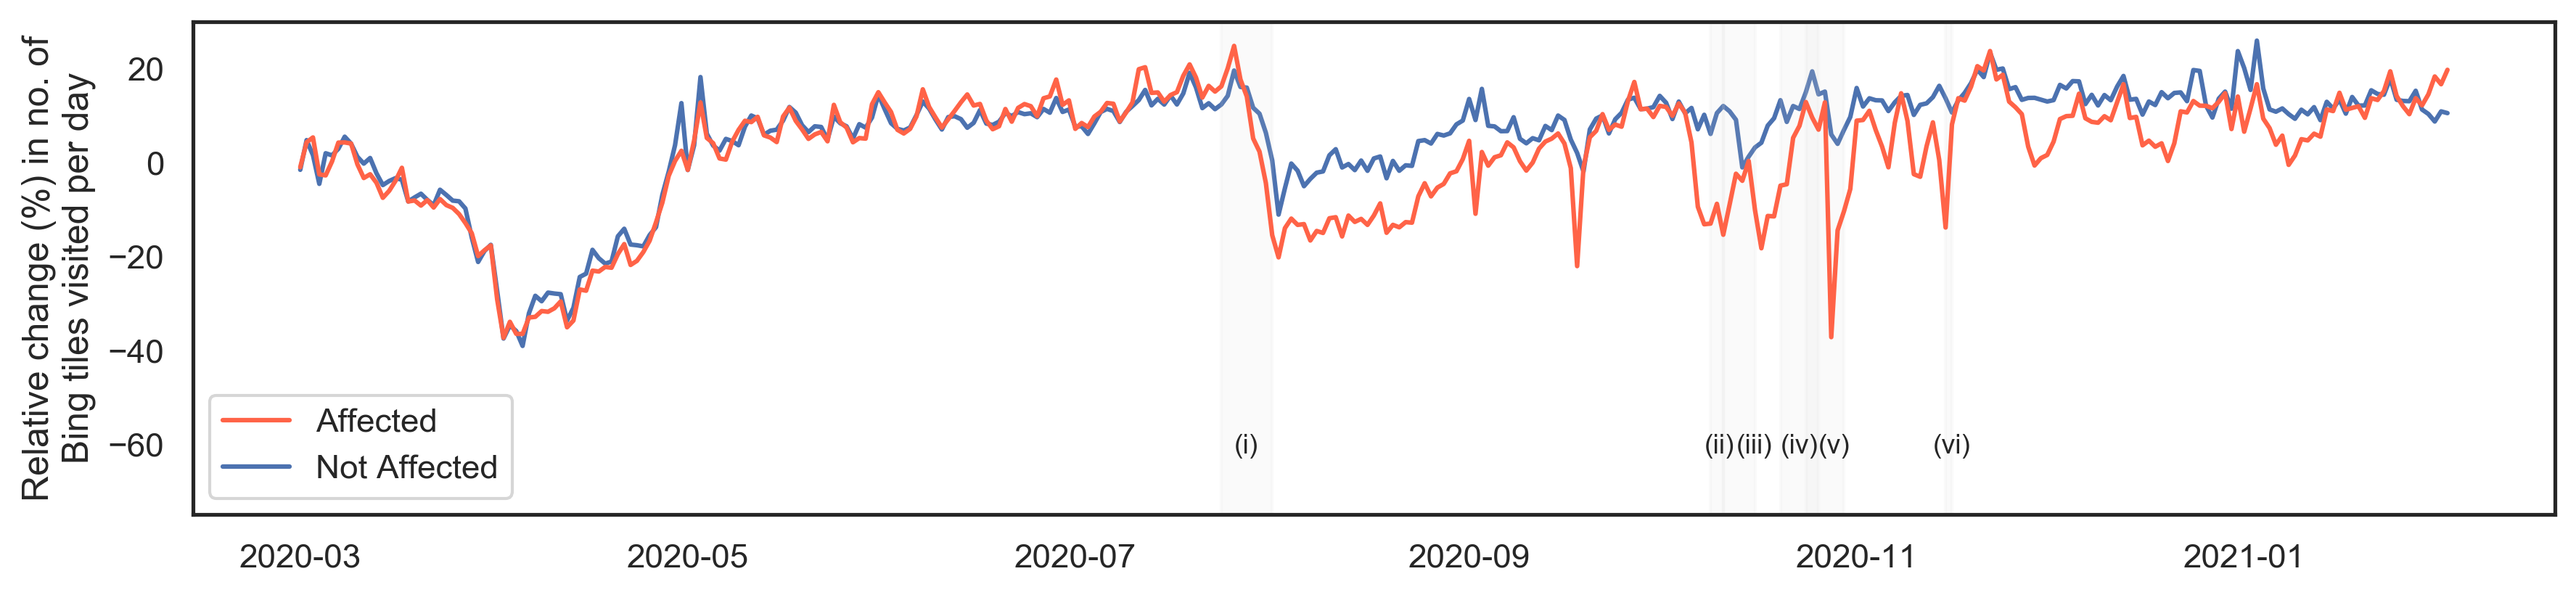

In [10]:
# Vietnam mobility
fig, ax = plt.subplots(figsize=(14,3),dpi=300)
label_height = -62

sns.lineplot(data=data[data['polygon_id'].isin(affected['VNM']['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='Tomato',ax=ax,zorder=100)
sns.lineplot(data=data[~data['polygon_id'].isin(affected['VNM']['GID_2'].unique())&(data['country']=='VNM')].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',ax=ax,zorder=-100)
plt.axvspan(datetime(2020,10,9),datetime(2020,10,11),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,11),datetime(2020,10,16),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,20),datetime(2020,10,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,10,24),datetime(2020,10,30),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,7,24),datetime(2020,8,1),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,15),datetime(2020,11,16),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,7,26),label_height,'(i)',fontsize=fontsize)
plt.text(datetime(2020,10,8),label_height,'(ii)',fontsize=fontsize)
plt.text(datetime(2020,10,13),label_height,'(iii)',fontsize=fontsize)
plt.text(datetime(2020,10,20),label_height,'(iv)',fontsize=fontsize)
plt.text(datetime(2020,10,26),label_height,'(v)',fontsize=fontsize)
plt.text(datetime(2020,11,13),label_height,'(vi)',fontsize=fontsize)

plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel('Relative change (%) in no. of\nBing tiles visited per day')
plt.ylim([-75,30])
# plt.text(datetime(2020,2,15),-110,'(i) Second-wave lockdown (Central VNM) (ii) Tropical Storm LINFA (iii) Tropical Storm NANGKA (iv) Tropical Storm SAUDEL (v) Tropical Cyclone\nMOLAVE(vi) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()


## Philippines

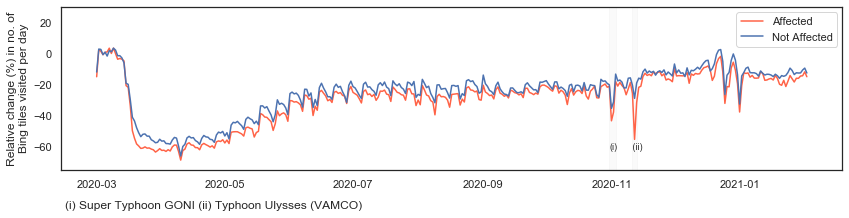

In [11]:
# Philippines mobility
fig, ax = plt.subplots(figsize=(14,3))

sns.lineplot(data=data[data['polygon_id'].isin(affected['PHL']['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(affected['PHL']['GID_2'].unique())&(data['country']=='PHL')].groupby('ds').mean().reset_index(),x='ds',y='all_day_bing_tiles_visited_percent_change',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),-62,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),-62,' (ii)',fontsize=fontsize)
plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylim([-75,30])
plt.ylabel('Relative change (%) in no. of\nBing tiles visited per day')
plt.text(datetime(2020,2,15),-100,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()

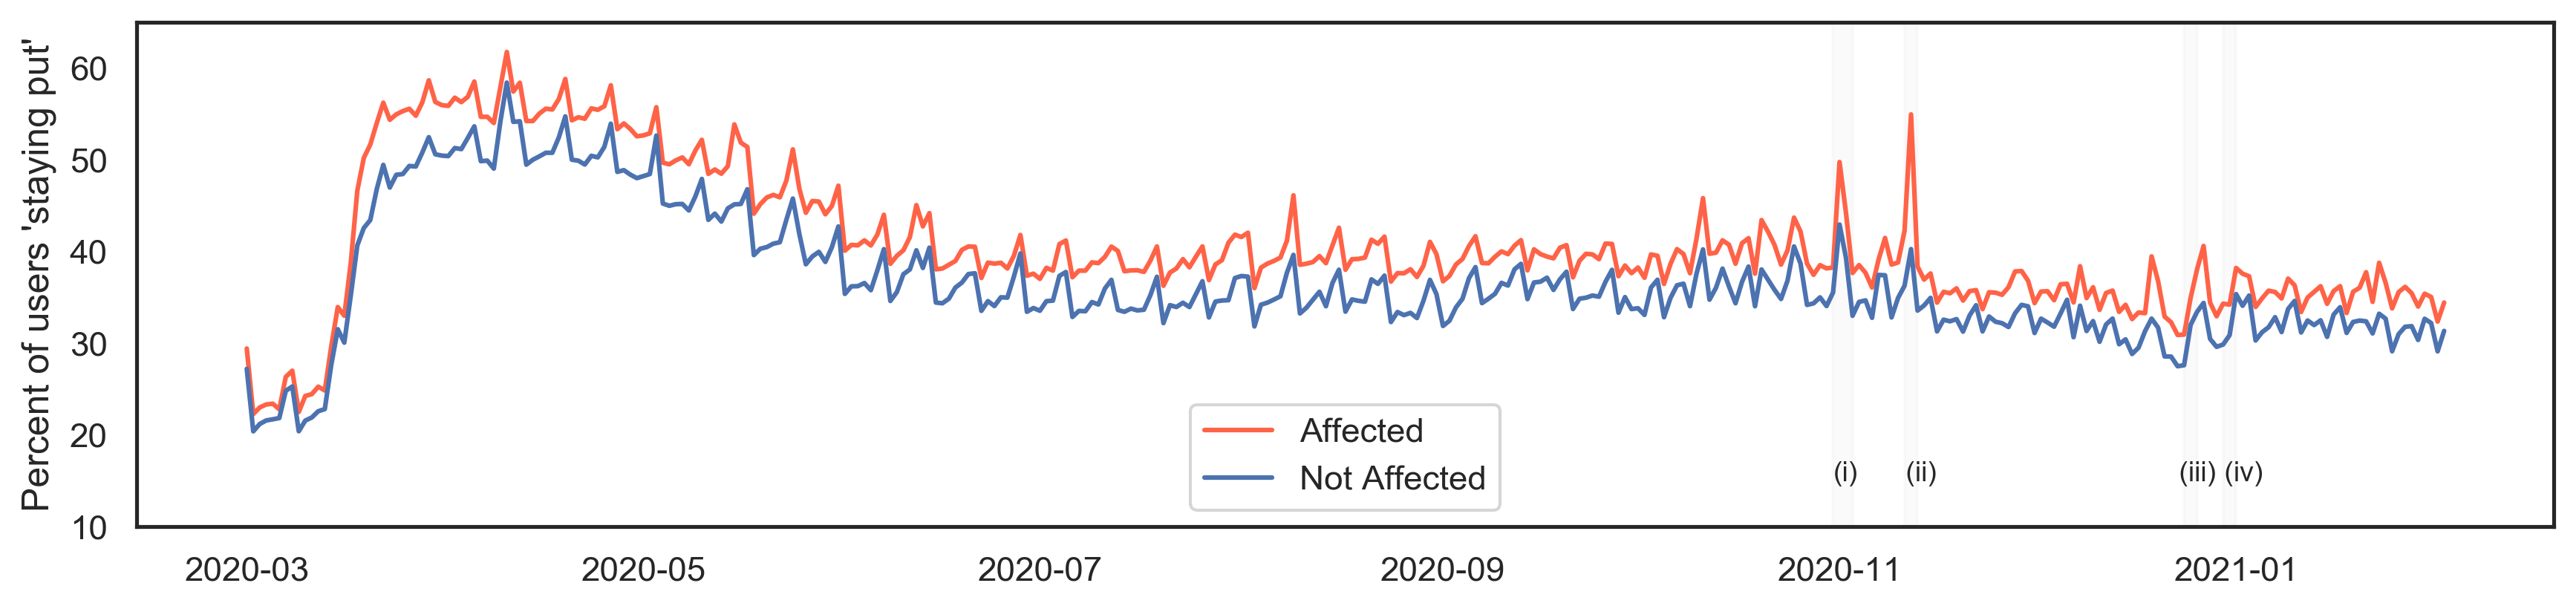

In [12]:
fig, ax = plt.subplots(figsize=(14,3),dpi=300)

sns.lineplot(data=data[data['polygon_id'].isin(affected['PHL']['GID_2'].unique())].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',color='Tomato',ax=ax)
sns.lineplot(data=data[~data['polygon_id'].isin(affected['PHL']['GID_2'].unique())&(data['country']=='PHL')].groupby('ds').mean().reset_index(),x='ds',y='all_day_percent_single_tile_users',ax=ax)
plt.axvspan(datetime(2020,10,31),datetime(2020,11,3),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,11,11),datetime(2020,11,13),color=color,zorder=-10,alpha=alpha)
plt.text(datetime(2020,10,31),15,'(i)',fontsize=fontsize)
plt.text(datetime(2020,11,10),15,' (ii)',fontsize=fontsize)

plt.axvspan(datetime(2020,12,24),datetime(2020,12,26),color=color,zorder=-10,alpha=alpha)
plt.axvspan(datetime(2020,12,30),datetime(2021,1,1),color=color,zorder=-10,alpha=alpha)

plt.text(datetime(2020,12,22),15,' (iii)',fontsize=fontsize)
plt.text(datetime(2020,12,29),15,' (iv)',fontsize=fontsize)

plt.legend(['Affected','Not Affected'])
plt.xlabel('')
plt.ylabel("Percent of users 'staying put'")
plt.ylim([10,65])
# plt.text(datetime(2020,2,15),-5,'(i) Super Typhoon GONI (ii) Typhoon Ulysses (VAMCO)',ha='left')
plt.show()

# Typhoon Vamco

In [13]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

col = cm.get_cmap('Reds', 6)
col(1)

(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0)

In [14]:
def color_selector(series):
    six = (series[series['ds']=='2020-9-1']['all_day_bing_tiles_visited_percent_change'])
    minimum = series[(series['ds']>'2020-11-3')&(series['ds']<'2020-11-20')]['all_day_bing_tiles_visited_percent_change'].min()
    return (six-minimum)

In [15]:
gadm_phl = gpd.read_file('data/boundaries/PHL/gadm36_PHL_2.shp')
gadm_vnm = gpd.read_file('data/boundaries/VNM/gadm36_VNM_2.shp')

In [16]:
phl = pd.merge(data[data['country']=='PHL'],gadm_phl,left_on='polygon_id',right_on='GID_2')
vnm = pd.merge(data[data['country']=='VNM'],gadm_vnm,left_on='polygon_id',right_on='GID_2')

(-75, 40)

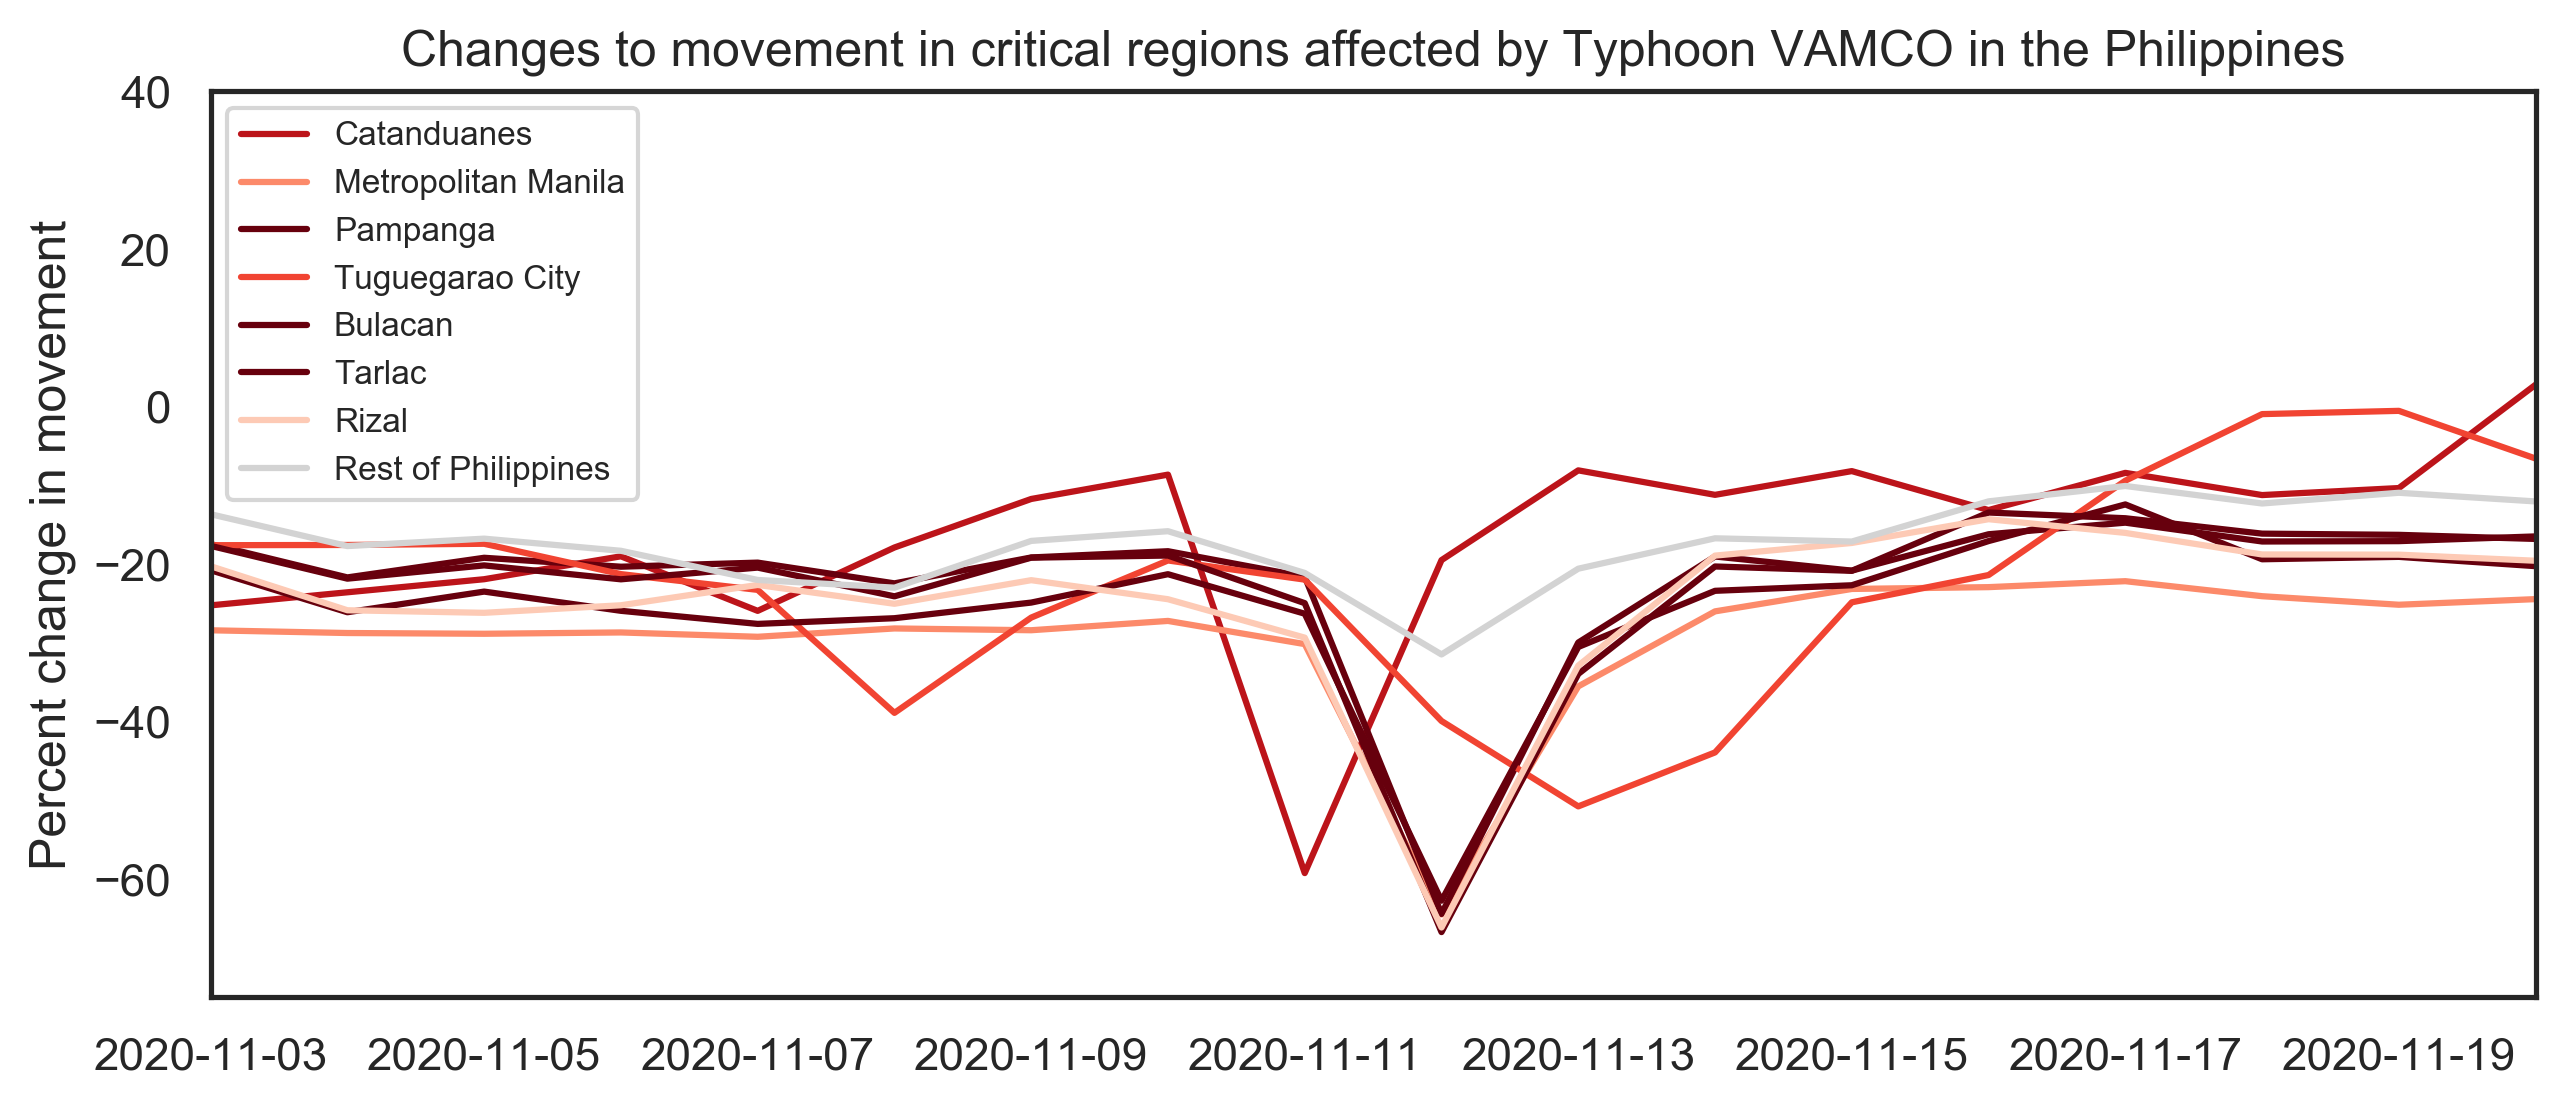

In [20]:
plt.figure(figsize=(10,4),dpi=300)
a = phl[phl['NAME_1']=='Catanduanes']\
    .groupby('ds').mean().reset_index()
b = phl[phl['NAME_1']=='Metropolitan Manila']\
    .groupby('ds').mean().reset_index()
c = phl[phl['NAME_1']=='Pampanga']\
    .groupby('ds').mean().reset_index()
d = phl[phl['NAME_2']=='Tuguegarao City']\
    .groupby('ds').mean().reset_index()
e = phl[phl['NAME_1']=='Bulacan']\
    .groupby('ds').mean().reset_index()
f = phl[phl['NAME_1']=='Tarlac']\
    .groupby('ds').mean().reset_index()
g = phl[phl['NAME_1']=='Rizal']\
    .groupby('ds').mean().reset_index()

cols = []
for i in [a,b,c,d,e,f,g]:
    cols.append(color_selector(i).values[0])
cols_ind = np.argsort(cols)

for n,i in enumerate([a,b,c,d,e,f,g]):
    sns.lineplot(i['ds'],i['all_day_bing_tiles_visited_percent_change'],color=col(cols_ind[n]+1))

z = phl[~phl['NAME_1'].isin(['Catanduanes','Metropolitan Manila','Pampanga','Bulacan','Tarlac','Rizal'])]\
    .groupby('ds').mean().reset_index()
sns.lineplot(z['ds'],z['all_day_bing_tiles_visited_percent_change'],color=color)

plt.xlim([datetime(2020,11,3),datetime(2020,11,20)])
plt.legend(['Catanduanes','Metropolitan Manila','Pampanga','Tuguegarao City','Bulacan','Tarlac','Rizal','Rest of Philippines'],fontsize=fontsize-1)
plt.ylabel('Percent change in movement')
plt.xlabel('')
plt.title('Changes to movement in critical regions affected by Typhoon VAMCO in the Philippines')
plt.ylim([-75,40])


(-75, 40)

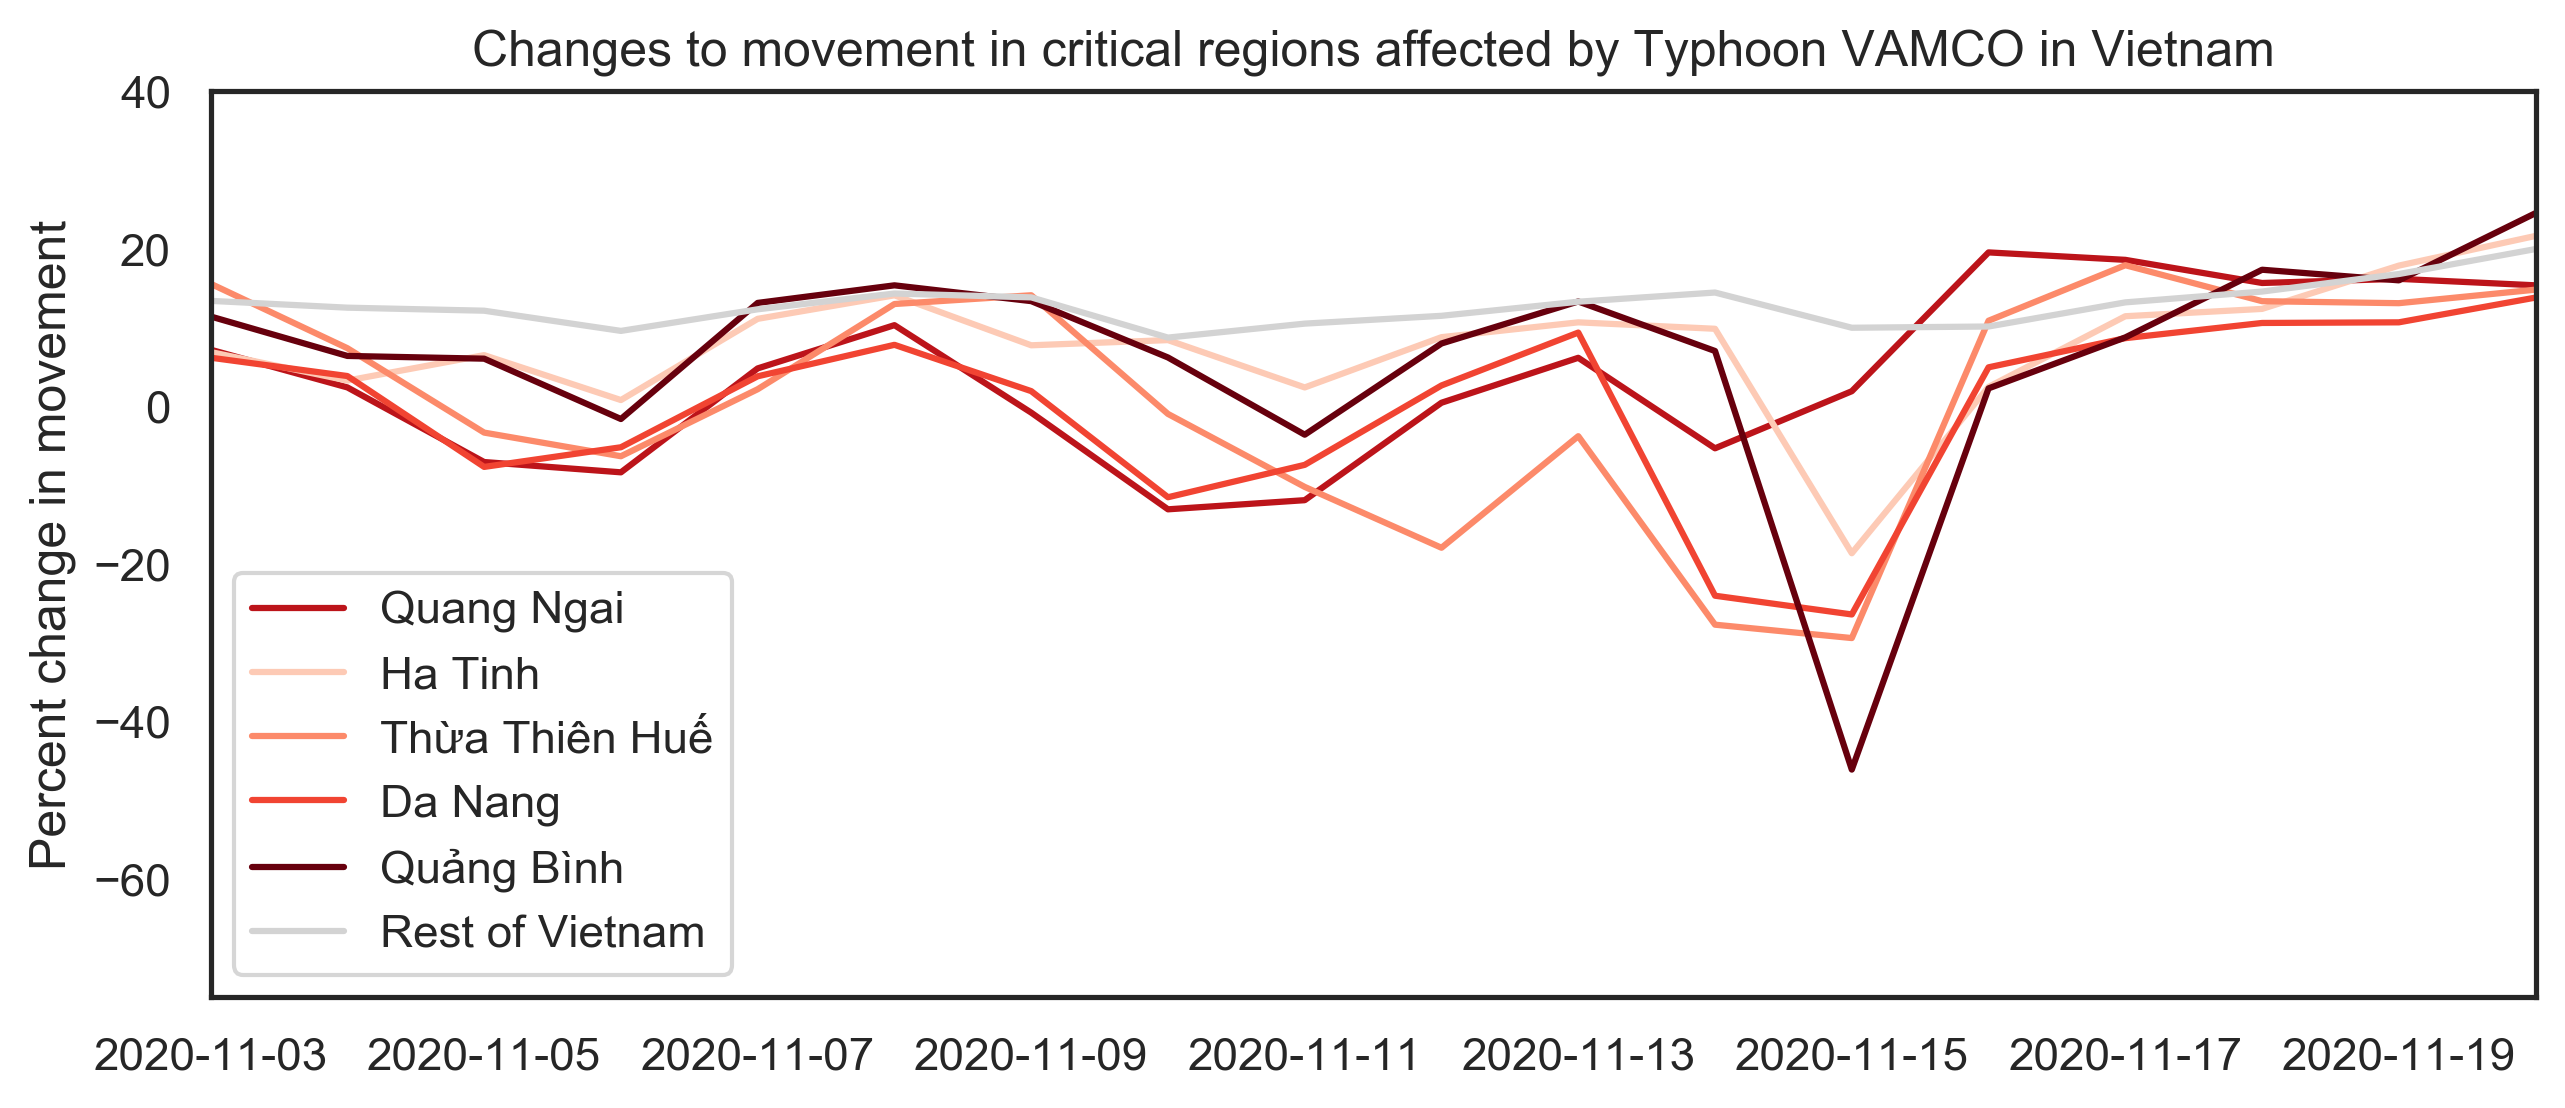

In [21]:
v = pd.DataFrame()
plt.figure(figsize=(10,4),dpi=300)
a = vnm[vnm['NAME_1']=='Quảng Ngãi']\
    .groupby('ds').mean().reset_index()
b = vnm[vnm['NAME_1']=='Hà Tĩnh']\
    .groupby('ds').mean().reset_index()
c = vnm[vnm['NAME_1']=='Thừa Thiên Huế']\
    .groupby('ds').mean().reset_index()
d = vnm[vnm['NAME_1']=='Đà Nẵng']\
    .groupby('ds').mean().reset_index()
e = vnm[vnm['NAME_1']=='Quảng Bình']\
    .groupby('ds').mean().reset_index()

cols = []
for i in [a,b,c,d,e]:
    cols.append(color_selector(i).values[0])
    v = pd.concat([v,i])
cols_ind = np.argsort(cols)

for n,i in enumerate([a,b,c,d,e]):
    sns.lineplot(i['ds'],i['all_day_bing_tiles_visited_percent_change'],color=col(cols_ind[n]+1))

z = vnm[~vnm['NAME_1'].isin(['Quảng Ngãi'])]\
    .groupby('ds').mean().reset_index()
sns.lineplot(z['ds'],z['all_day_bing_tiles_visited_percent_change'],color=color)
v = pd.concat([v,z])
plt.xlim([datetime(2020,11,3),datetime(2020,11,20)])
plt.legend(['Quang Ngai','Ha Tinh','Thừa Thiên Huế','Da Nang','Quảng Bình','Rest of Vietnam'])
plt.ylabel('Percent change in movement')
plt.xlabel('')
plt.title('Changes to movement in critical regions affected by Typhoon VAMCO in Vietnam')
plt.ylim([-75,40])
